# Import needed modules

In [1]:
# Import System Libraries
import os
import warnings
from PIL import Image
import rasterio
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, 
    Activation, Dropout, BatchNormalization, 
    GlobalAveragePooling2D, Lambda, Conv2DTranspose
)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Set Seaborn style for plots
sns.set_style('darkgrid')

# Ignore Warnings
warnings.filterwarnings("ignore")

print('Modules loaded.')

Modules loaded.


# 1_Data Preprocessing

## 1.1 Data Preparation

In [2]:
# 1.1 Data Preparation
# Directories containing images and labels
image_dir = '/kaggle/input/water-data/data/images'
label_dir = '/kaggle/input/water-data/data/labels'

# Initialize dictionaries to map filenames to their data
image_dict = {}
label_dict = {}

# Read TIFF images and store in dictionary
for file in os.listdir(image_dir):
    if file.endswith('.tif'):
        file_path = os.path.join(image_dir, file)
        with rasterio.open(file_path) as src:
            image = src.read()
            image_dict[os.path.splitext(file)[0]] = image

# Read PNG labels and store in dictionary
for file in os.listdir(label_dir):
    if file.endswith('.png'):
        file_path = os.path.join(label_dir, file)
        with rasterio.open(file_path) as src:
            label = src.read()
            label_dict[os.path.splitext(file)[0]] = label

# Ensure that filenames match between images and labels
common_filenames = set(image_dict.keys()) & set(label_dict.keys())

# Initialize lists to store image and label arrays
images = []
labels = []

# Collect data for common filenames
for filename in common_filenames:
    images.append(image_dict[filename])
    labels.append(label_dict[filename])

# Convert lists to NumPy arrays
images_np = np.array(images)
labels_np = np.array(labels)

## 1.2 Normalization

In [3]:
# Normalize images to the range [0, 1]
min_value = np.min(images_np)
max_value = np.max(images_np)
images_np = (images_np - min_value) / (max_value - min_value)

# Ensure labels are in the range [0, 1]
labels_np = labels_np / np.max(labels_np)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images_np, labels_np, test_size=0.2, random_state=42)

# Print shapes and ranges for verification
print(f"Training images shape: {x_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Images range: {x_train.min()} to {x_train.max()}")
print(f"Labels range: {y_train.min()} to {y_train.max()}")

Training images shape: (244, 12, 128, 128)
Validation images shape: (62, 12, 128, 128)
Training labels shape: (244, 1, 128, 128)
Validation labels shape: (62, 1, 128, 128)
Images range: 0.0 to 1.0
Labels range: 0.0 to 1.0


# 2_Visualization

## 2.1 Visualizing Multispectral Bands

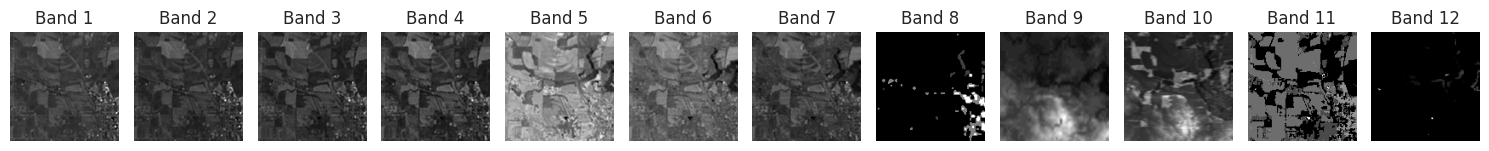

In [4]:
# Select an index of the image you want to visualize
sample_index = 0

# Select the image data for the chosen sample
image_sample = images_np[sample_index]

# Number of bands in the image
num_bands = image_sample.shape[0]

# Create a subplot for each band
fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))

# Display each band
for i in range(num_bands):
    axes[i].imshow(image_sample[i], cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 2.2 Visualizing a Random Sample from the Dataset

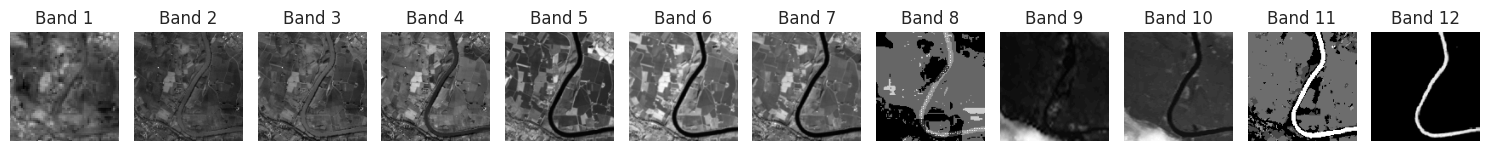

In [5]:
# Randomly select an index of the image you want to visualize
sample_index = np.random.randint(0, len(images_np))

# Select the image data for the chosen sample
image_sample = images_np[sample_index]

# Create a subplot for each band
fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))

# Display each band
for i in range(num_bands):
    axes[i].imshow(image_sample[i], cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 2.3 Visualizing Labels

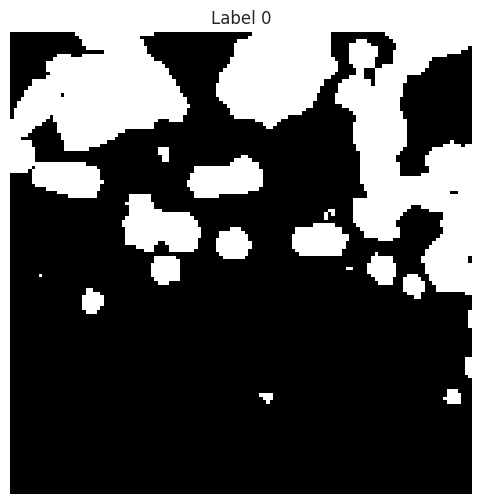

In [6]:
# Select the index of the label you want to visualize
label_index = 0

# Select the label data for the chosen sample
label_sample = labels_np[label_index, 0]  # Assuming single channel

# Display the label
plt.figure(figsize=(6, 6))
plt.imshow(label_sample, cmap='gray')
plt.title(f'Label {label_index}')
plt.axis('off')
plt.show()

# 3_Model Architecture and Training

## (U-Net Architecture)

In [7]:
input_size=(128, 128, 12)
def unet_model(input_size):
    inputs = layers.Input(input_size)
    
    # Encoding path
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    
    # Decoding path
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Create the U-Net model with the correct input size
unet = unet_model(input_size)
# Compile the U-Net model
unet.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
             loss='binary_crossentropy', 
             metrics=['accuracy'])

# Model summary
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [8]:
batch_size = 16
epochs = 35

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
# Transpose the image data from (12, 128, 128) to (128, 128, 12)
images_np = images_np.transpose((0, 2, 3, 1))

# Ensure the labels are in the correct shape if necessary (should be (128, 128, 1) or similar)
labels_np = labels_np.transpose((0, 2, 3, 1))

# Now, proceed with the train-test split
x_train, x_val, y_train, y_val = train_test_split(images_np, labels_np, test_size=0.2, random_state=42)

# Proceed with training using the new U-Net model
history = unet.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/35


I0000 00:00:1725464524.883710      70 service.cc:145] XLA service 0x7a3ed0001410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725464524.883825      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/15 ━━━━━━━━━━━━━━━━━━━━ 5:26 23s/step - accuracy: 0.2546 - loss: 0.7028

I0000 00:00:1725464539.907762      70 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_compare_reduce_fusion_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1725464539.917746      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6441 - loss: 0.6212 - val_accuracy: 0.7240 - val_loss: 0.5753
Epoch 2/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7555 - loss: 0.5491 - val_accuracy: 0.7240 - val_loss: 0.5726
Epoch 3/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.7383 - loss: 0.5647 - val_accuracy: 0.7240 - val_loss: 0.5704
Epoch 4/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8492 - loss: 0.4247 - val_accuracy: 0.7240 - val_loss: 0.5767
Epoch 5/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.7560 - loss: 0.5447 - val_accuracy: 0.7240 - val_loss: 0.5664
Epoch 6/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7916 - loss: 0.5213 - val_accuracy: 0.7240 - val_loss: 0.5637
Epoch 7/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7601 - loss: 0.5411 - val_accuracy: 0.7240 - val_loss: 0.5579
Epoch 8/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7285 - loss: 0.5561 - val_accuracy: 0.7240 - val_loss: 

# 4_Evaluate model


In [9]:
val_loss, val_accuracy = unet.evaluate(x_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

# Predictions
y_pred = unet.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8936 - loss: 0.3103
Validation Accuracy: 89.29%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


## Model Visualization

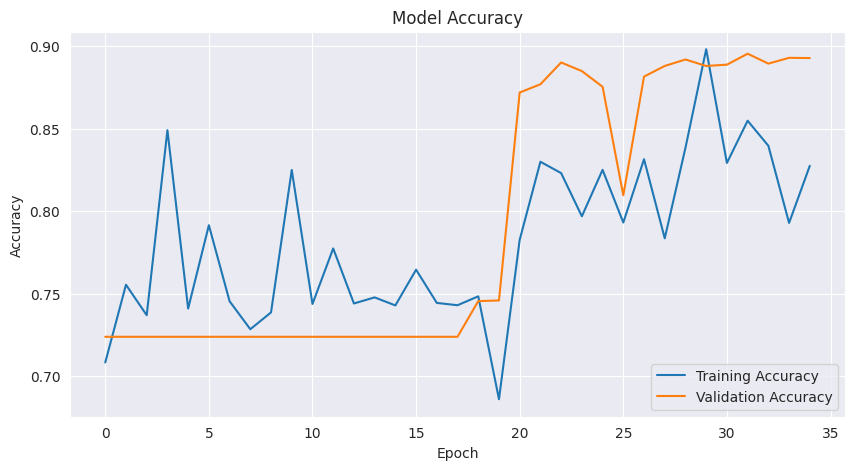

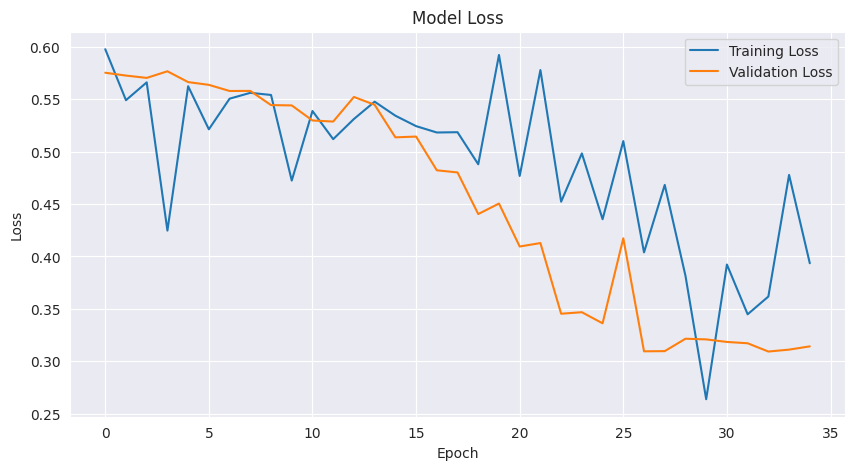

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


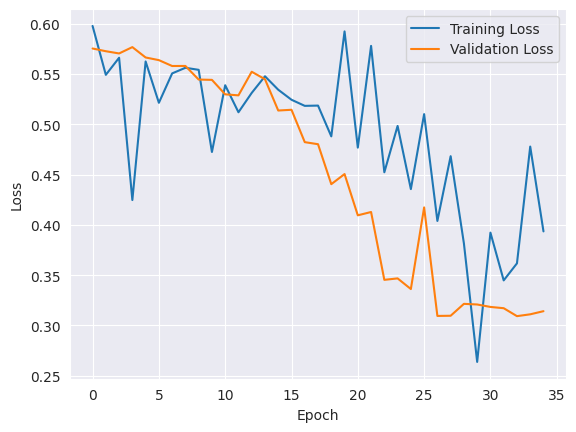

In [11]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## compute IoU, precision, recall, and F1-score

In [12]:
def compute_metrics(y_true, y_pred):
    # Flatten arrays for metric calculations
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Binarize predictions
    y_pred_binary = (y_pred_flat > 0.5).astype(int)  # Assuming a threshold of 0.5

    # Calculate metrics
    iou = np.sum((y_true_flat == 1) & (y_pred_binary == 1)) / np.sum((y_true_flat == 1) | (y_pred_binary == 1))
    precision = precision_score(y_true_flat, y_pred_binary)
    recall = recall_score(y_true_flat, y_pred_binary)
    f1 = f1_score(y_true_flat, y_pred_binary)

    return iou, precision, recall, f1

# Generate predictions (assuming you have a trained model)
y_pred_prob = unet.predict(x_val)  # Get predictions in probability format

# Binarize predictions
y_pred = (y_pred_prob > 0.5).astype(int)  # Assuming a threshold of 0.5

# Compute metrics
iou, precision, recall, f1 = compute_metrics(y_val, y_pred)

print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
IoU: 0.6322
Precision: 0.9242
Recall: 0.6667
F1 Score: 0.7746


# Save model

In [13]:
unet.save('Water Segmentation.h5')